In [1]:
# Install libraries
!pip install tensorflow-probability
!pip install imageio

In [1]:
# Import General Utilities
import numpy as np
import os
import random
from tqdm.notebook import tqdm, trange
import time
import datetime

#Import tensorflow and its requirements
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.datasets as tfds
import tensorflow.experimental.numpy as tnp
from tensorflow.data.experimental import cardinality as dlen
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE
tnp.experimental_enable_numpy_behavior()

# Import plotting tools and image converters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import imageio
from IPython import display
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# Import file path variable handling
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Constants
from main_functions import load_globals, load_oasis_datasets, VQVAE, pixel_cnn, configure_for_performance, gen_codebooks
batch_size = 20
buffer_size = 64
epochs = 400
img_height = 256
img_width = 256
num_examples_to_generate = 8

print(tf.__version__)

2.7.0-dev20210803


In [2]:
# Download OASIS Dataset from the provided link
load_globals(img_width, img_height, batch_size, buffer_size)
train_ds, train_ds_raw, test_ds, test_ds_raw, val_ds, val_ds_raw = load_oasis_datasets('/root/.keras/datasets')

Data Directory is \root\.keras\datasets\keras_png_slices_data
Train Set is 9664 images, Test Set is 544 images and Validation Set is 1120 images.


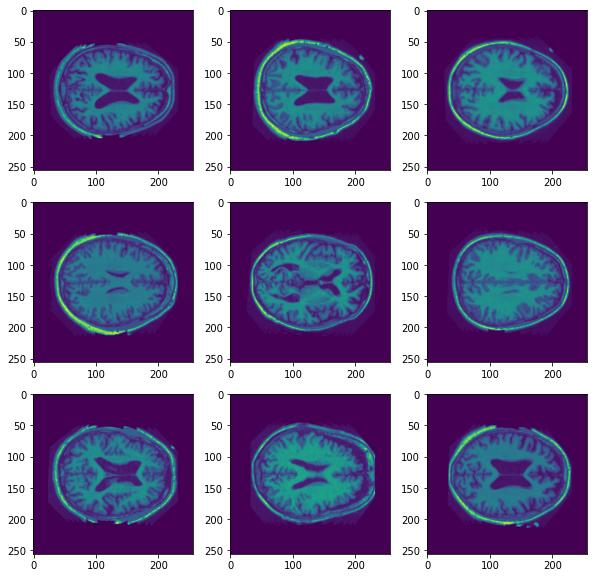

In [3]:
# Show the first scan of 9 patients in the training set
image_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i][:, :, 0])

plt.show()

In [10]:
# Adapted from the Keras VQVAE tutorial - https://keras.io/examples/generative/vq_vae/
class VQVAETrainer(tf.keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, model=None, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        if model is None:
            self.vqvae = VQVAE(self.latent_dim, self.num_embeddings)
        else:
            self.vqvae = model

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = tf.keras.metrics.Mean(name="vq_loss")
        self.ssim = tf.keras.metrics.Mean(name="ssim")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
            self.ssim,
        ]

    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

            ssim_score = tf.image.ssim(x + 0.5, reconstructions + 0.5, max_val=1.0)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))
        self.ssim.update_state(ssim_score)

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
            "ssim": self.ssim.result(),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [11]:
def generate_and_save_images(model, epoch, test_sample, save_dir):
    encoded_t, encoded_b = model.encode(test_sample)
    predictions = model.decode(encoded_t, encoded_b)
    fig = plt.figure(figsize=(4 * num_examples_to_generate, 8))

    for i in range(num_examples_to_generate):

        # display original + noise
        ax = plt.subplot(2, num_examples_to_generate, i + 1)
        plt.title("Original")
        plt.imshow(test_sample[i][:, :, 0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, num_examples_to_generate, i + num_examples_to_generate + 1)
        plt.title("Reconstruction")
        plt.imshow(predictions[i][:, :, 0])
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig(save_dir / f'image_at_epoch_{epoch:04}.png')

    plt.show()

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in val_ds.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

# Create folders to store trained models and generated images in
model_path = Path('/root/trained_model')
if not os.path.exists(model_path):
    os.makedirs(model_path)
model_no = len(os.listdir(model_path)) + 1

model_path = model_path / f'model{model_no:03}'

save_path = Path('/root/image_sets')
if not os.path.exists(save_path):
    os.makedirs(save_path)
image_path = save_path / f'model{model_no:03}'
os.makedirs(image_path)

Epoch: 400/400
484/484 95s 194ms/step - loss: 1691158.125 - reconstruction_loss: 0.17030377686023712 - vqvae_loss: 1691158.125 - SSIM: 0.8171492218971252
Vector Quantizer t_vq has input shape [  8  32  32 256] and flattened shape (8192, 256)
Num Embeddings = 256, (256, 256)
Vector Quantizer b_vq has input shape [  8  64  64 128] and flattened shape (32768, 128)
Num Embeddings = 128, (128, 256)


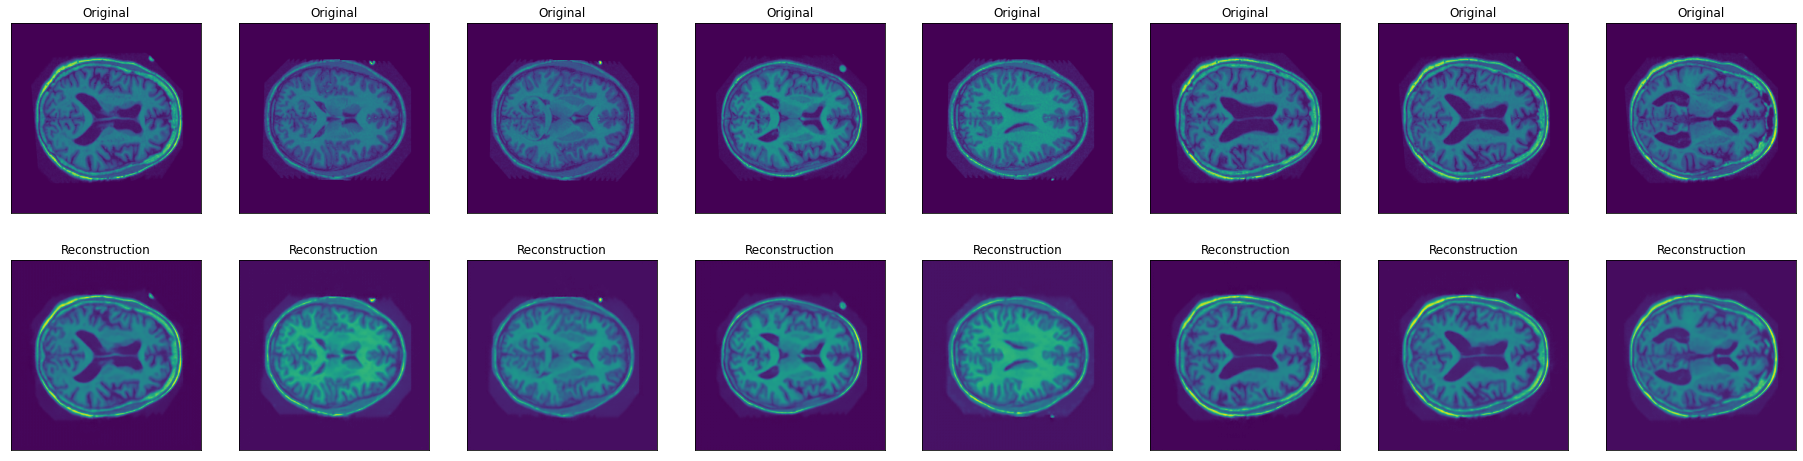

In [12]:
vqvae_trainer = VQVAETrainer(0.02, latent_dim=128, num_embeddings=256)
vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
#vqvae_trainer.fit(train_ds, epochs=5, batch_size=batch_size) - can be used instead of below if incremental images are undesired

generate_and_save_images(vqvae_trainer.vqvae, 0, test_sample, image_path)
loss_lists = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    step_time = 0
    iters = 0
    for train_x in tqdm(train_ds, desc=f"Epoch {epoch}/{epochs} - Model Step"):
        step_start = time.time()
        losses = vqvae_trainer.train_step(train_x)
        step_time = step_time + time.time() - step_start
        iters = iters + 1
    end_time = time.time()
    step_time = step_time / iters

    # Clear the output and print out information about the current training step
    display.clear_output(wait=False)
    print(f"Epoch: {epoch}/{epochs}\n{iters}/{iters} {round(end_time - start_time)}s {round(step_time * 1000)}ms/step - loss: {losses['loss']} - reconstruction_loss: {losses['reconstruction_loss']} - vqvae_loss: {losses['vqvae_loss']} - SSIM: {losses['ssim']}")
    generate_and_save_images(vqvae_trainer.vqvae, epoch, test_sample, image_path)
    loss_lists.append([losses['loss'], losses['reconstruction_loss'], losses['vqvae_loss'], losses['ssim']])


In [4]:
def show_subplot(original, reconstructed):

    original = original + 0.5
    reconstructed = reconstructed + 0.5

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original[:, :, 0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[:, :, 0])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

# Save the trained model and test the training on data from the test set
trained_vqvae_model = vqvae_trainer.vqvae
trained_vqvae_model.save(model_path, save_traces=True)
test_images = next(iter(test_ds))
reconstructions_test = trained_vqvae_model.predict(test_images)

for i in range(5):
    show_subplot(test_images[i], reconstructions_test[i])


NameError: name 'vqvae_trainer' is not defined

Vector Quantizer t_vq has input shape [ 20  32  32 256] and flattened shape (20480, 256)
Num Embeddings = 256, (256, 256)
Vector Quantizer b_vq has input shape [ 20  64  64 128] and flattened shape (81920, 128)
Num Embeddings = 128, (128, 256)
Low filter encoder is (20, 32, 32, 256), High filter encoder is (20, 64, 64, 128)


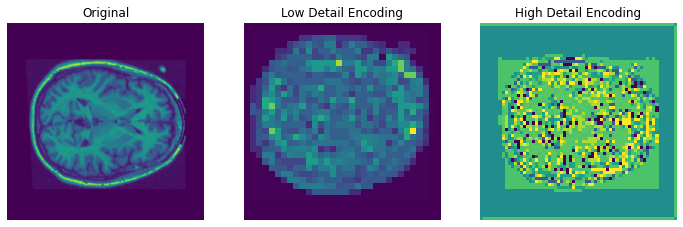

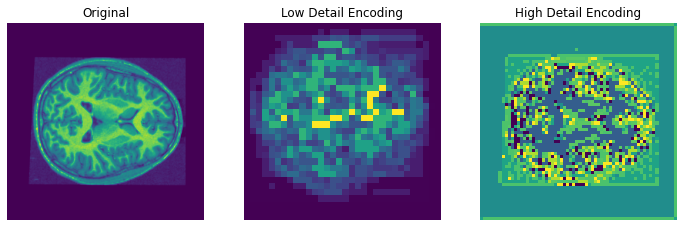

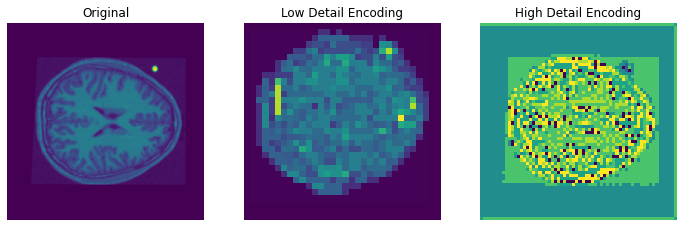

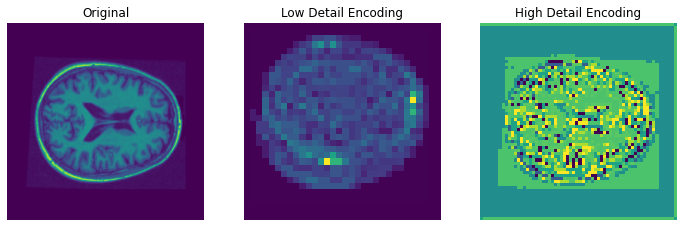

In [14]:
# Testing encoding visualisation
enc_out_t, enc_out_b = trained_vqvae_model.encode(test_images)
#enc_out = trained_vqvae_model.encode(test_images)
print(f"Low filter encoder is {enc_out_t.shape}, High filter encoder is {enc_out_b.shape}")
#print(f"Vector encoder is {enc_out.shape}.")

for i in range(4):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i][:, :, 0] + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(enc_out_t[i][:, :, 0] + 0.5) # 64 Filters
    plt.title("Low Detail Encoding")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(enc_out_b[i][:, :, 0] + 0.5) # 256 Filters
    plt.title("High Detail Encoding")
    plt.axis("off")
    plt.show()
# One hot encode the vector spaces to collapse them down.


In [20]:
ssim_total = 0
count = 0

for batch in tqdm(test_ds):
    reconstructed_comp = trained_vqvae_model.predict(batch)

    for i in range(batch.shape[0]):
        original = tf.math.round((batch[i] + 0.5) * 255.0)
        reconstruction = tf.math.round((reconstructed_comp[i] + 0.5) * 255.0)
        ssim = tf.image.ssim(original, reconstruction, max_val=255.0)
        ssim_total += ssim
        count += 1

print(f"Average SSIM score is {ssim_total / count}.")

  0%|          | 0/28 [00:00<?, ?it/s]

Average SSIM score is 0.9380497336387634.


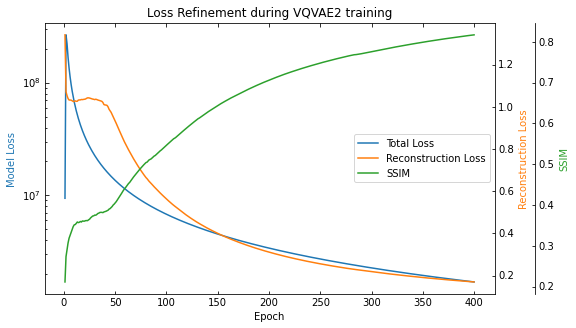

In [21]:
t_loss = []
r_loss = []
v_loss = []
ssims = []
xpoints = []

for group in loss_lists:
    t_loss.append(group[0])
    r_loss.append(group[1])
    v_loss.append(group[2])
    ssims.append(group[3])

for i in range(len(loss_lists)):
    xpoints.append(i + 1)

plt.figure(figsize=[10,5])

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 40
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

p1, = host.plot(xpoints, t_loss, label='Total Loss')
#p2, = host.plot(xpoints, v_loss, label='VQVAE Loss')
p3, = par1.plot(xpoints, r_loss, label='Reconstruction Loss')

p4, = par2.plot(xpoints, ssims, label='SSIM')

host.set_xlabel("Epoch")
host.set_title("Loss Refinement during VQVAE2 training")
host.set_ylabel("Model Loss")
host.set_yscale('log')
par1.set_ylabel("Reconstruction Loss")
par2.set_ylabel("SSIM")

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p3.get_color())
par2.axis["right"].label.set_color(p4.get_color())

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.legend(loc='center right')

plt.draw()
plt.savefig('/root/testfile.png')
plt.show()

In [48]:
# Generate an encoded dataset for the PixelCNN
pixel_ds = configure_for_performance(train_ds_raw, 10)
codebook_tensor_t, codebook_tensor_b = gen_codebooks(trained_vqvae_model, pixel_ds)
        

Extracting Codebook Indices::   0%|          | 0/967 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Vector Quantizer b_vq has input shape [ 10  64  64 128] and flattened shape (40960, 128)
Num Embeddings = 128, (128, 256)
Vector Quantizer t_vq has input shape [ 10  32  32 256] and flattened shape (10240, 256)
Num Embeddings = 256, (256, 256)
Vector Quantizer t_vq has input shape [ 10  32  32 256] and flattened shape (10240, 256)
Num Embeddings = 256, (256, 256)
Vector Quantizer b_vq has input shape [ 10  64  64 128] and flattened shape (40960, 128)
Num Embeddings = 128, (128, 256)
Vector Quantizer t_vq has input shape [ 10  32  32 256] and flattened shape (10240, 256)
Num Embeddings = 256, (256, 256)
Vector Quantizer t_vq has input shape [ 10  32  32 256] and flattened shape (10240, 256)
Num Embeddings = 256, (256, 256)
Vector Quantizer b_vq has input shape [ 10  64  64 128] and flattened shape (40960, 128)
Num Embeddings = 128, (128, 256)
Vector Quantizer t_vq has input shape [ 10  32  32 256] and flattened shape (10240, 256)
Num Em

In [60]:
# Compile and generate the PixelCNN models for each layer of the VQVAE
pixel_cnn_t = pixel_cnn((32, 32), filters=128, kernels=11, embeddings=512, name="pixel_cnn_top")
pixel_cnn_b = pixel_cnn((64, 64), filters=128, kernels=11, embeddings=256, name="pixel_cnn_bottom")

pixel_cnn_t.compile(
    optimizer=tf.keras.optimizers.Adam(4e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

pixel_cnn_b.compile(
    optimizer=tf.keras.optimizers.Adam(4e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

pixel_cnn_t.fit(
    x=codebook_tensor_t,
    y=codebook_tensor_t,
    batch_size=128,
    epochs=50,
    validation_split=0.1,
)

pixel_cnn_b.fit(
    x=codebook_tensor_b,
    y=codebook_tensor_b,
    batch_size=128,
    epochs=50,
    validation_split=0.1,
)

Epoch 1/50
68/68 [==============================] - 13s 191ms/step - loss: 6.1183 - val_loss: 5.7514
Epoch 2/50
68/68 [==============================] - 13s 189ms/step - loss: 4.3182 - val_loss: 3.2812
Epoch 3/50
68/68 [==============================] - 13s 190ms/step - loss: 2.8951 - val_loss: 2.5645
Epoch 4/50
68/68 [==============================] - 13s 190ms/step - loss: 2.3356 - val_loss: 2.1356
Epoch 5/50
68/68 [==============================] - 13s 193ms/step - loss: 1.9864 - val_loss: 1.8621
Epoch 6/50
68/68 [==============================] - 13s 190ms/step - loss: 1.7836 - val_loss: 1.7274
Epoch 7/50
68/68 [==============================] - 13s 189ms/step - loss: 1.6846 - val_loss: 1.6522
Epoch 8/50
68/68 [==============================] - 13s 189ms/step - loss: 1.6223 - val_loss: 1.6012
Epoch 9/50
68/68 [==============================] - 13s 188ms/step - loss: 1.5796 - val_loss: 1.5649
Epoch 10/50
68/68 [==============================] - 13s 191ms/step - loss: 1.5469 - val_lo

In [64]:
pixel_cnn_t.save(Path(os.getcwd()) / "models/model022_pixelcnn_t")
pixel_cnn_b.save(Path(os.getcwd()) / "models/model022_pixelcnn_b")

INFO:tensorflow:Assets written to: /root/trained_pixel_model/model022_pixelcnn_t\assets


INFO:tensorflow:Assets written to: /root/trained_pixel_model/model022_pixelcnn_t\assets


INFO:tensorflow:Assets written to: /root/trained_pixel_model/model022_pixelcnn_b\assets


INFO:tensorflow:Assets written to: /root/trained_pixel_model/model022_pixelcnn_b\assets


In [65]:
# Create a mini sampler model
def gen_priors_layer(model, num_samples=10):
    inputs = Input(shape=model.input_shape[1:])
    x = model(inputs, training=False)
    dist = tfp.distributions.Categorical(logits=x)
    sampled = dist.sample()
    sampler = Model(inputs, sampled)

    # Create an empty array of priors.
    priors = np.zeros(shape=(num_samples,) + (model.input_shape)[1:])
    num_samples, rows, cols = priors.shape

    # Iterate over the priors because generation has to be done sequentially pixel by pixel.
    for row in trange(rows, desc="Predicting priors"):
        for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = sampler.predict(priors)
            # Use the probabilities to pick pixel values and append the values to the priors.
            priors[:, row, col] = probs[:, row, col]
    return priors

priors_t = gen_priors_layer(pixel_cnn_t)
priors_b = gen_priors_layer(pixel_cnn_b)

Predicting priors:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting priors:   0%|          | 0/64 [00:00<?, ?it/s]

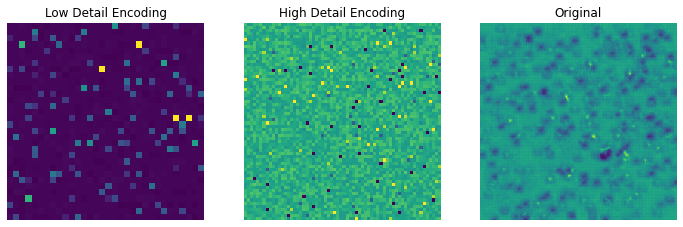

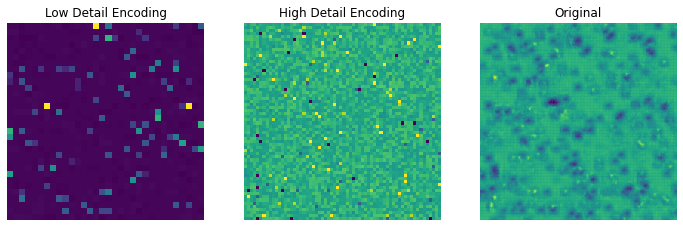

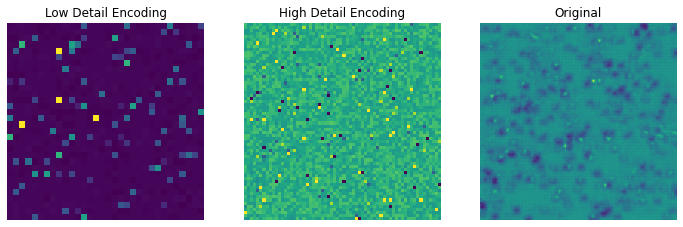

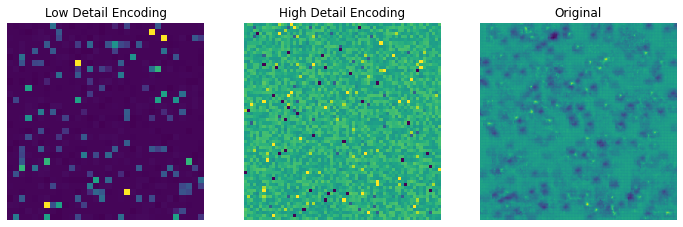

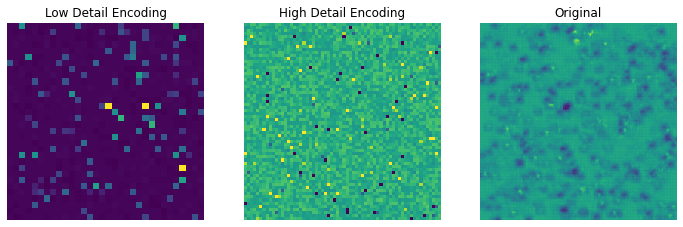

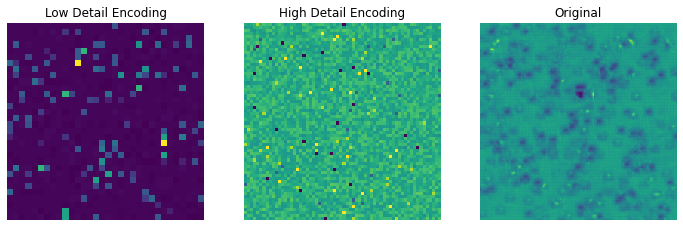

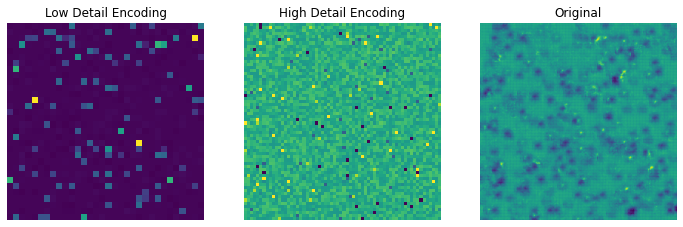

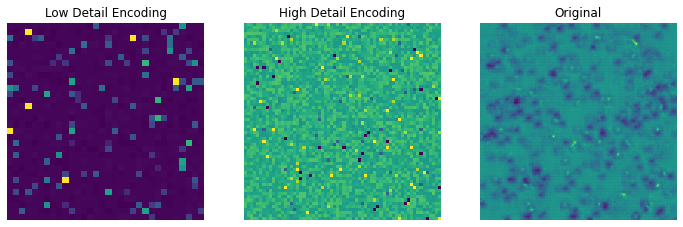

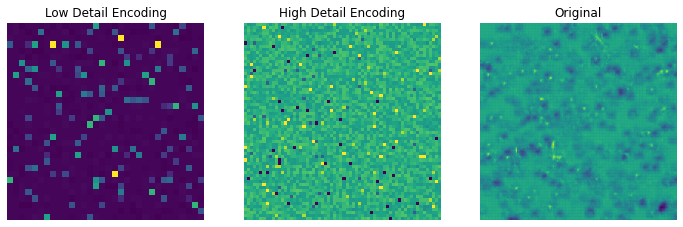

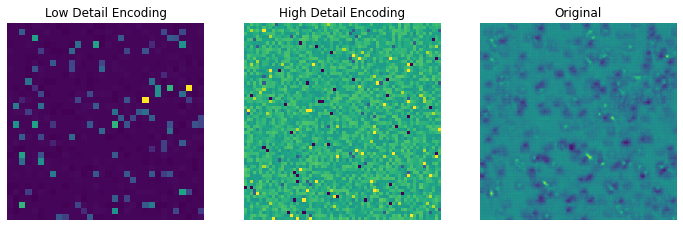

In [68]:
def show_generated_image(samples_t, samples_b):

    generated = trained_vqvae_model.decode(samples_t, samples_b)

    for i in range(samples_t.shape[0]):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(samples_t[i][:, :, 0] + 0.5)
        plt.title("Low Detail Encoding")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(samples_b[i][:, :, 0] + 0.5)
        plt.title("High Detail Encoding")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(generated[i][:, :, 0] + 0.5)
        plt.title("Original")
        plt.axis("off")

        plt.show()

def gen_encodings(priors, quantizer):
    # Perform an embedding lookup - same code from in VectorQuantizer
    encodings = tf.one_hot(priors, quantizer.num_embeddings)
    quantized = tf.matmul(encodings, quantizer.embeddings, transpose_b=True)
    quantized = tf.reshape(quantized, priors.shape + (quantizer.embedding_dim,))

    return quantized

pad_t = gen_encodings(priors_t, trained_vqvae_model.quantize_t)
pad_b = gen_encodings(priors_b, trained_vqvae_model.quantize_b)

show_generated_image(pad_t, pad_b)